# Introduction 

**This Notebook is used to label the tiled dataset based on cancerous vs. non-cancerous tissue**

- Binary Classificatio of Tiles
- Inference on non-labeled dataset
- Model trained on masked (sub-)dataset

In [1]:
"""!pip install --quiet mlflow dagshub
import mlflow.pytorch 
from mlflow import MlflowClient"""

'!pip install --quiet mlflow dagshub\nimport mlflow.pytorch \nfrom mlflow import MlflowClient'

In [2]:
# Standard library imports
import copy
import datetime
import gc
import glob
import heapq
import joblib
import math
import os
import random
import time
from collections import defaultdict
from itertools import chain

# Related third-party imports
import albumentations as A
import cv2
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations.pytorch import ToTensorV2
from colorama import Fore, Back, Style
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch.cuda import amp
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, tqdm_notebook

# Local application/library specific imports
# (Your local imports here, if any)/kaggle/input/ubc-binary-cancer-tissue-classifier-wsi-0-25x/label_encoder.pkl

# Set up for colored terminal text
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

# Disable warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

pd.set_option('display.max_colwidth', None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from ubc_utils_infrastructure import create_img_dataframe_from_directory
from ubc_utils_models import UBCBinaryModel


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.3.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
ydata-profiling 4.3.1 requires scipy<1.11,>=1.4.1, but you have scipy 1.11.2 which is incompatible.


In [4]:
CONFIG = {
    "datetime_now": datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"), 
    "seed": 42,
    "img_size": 512,
    "model_name": "tf_efficientnet_b0_ns",   # "tf_efficientnet_b0_ns", # "tf_efficientnetv2_s_in21ft1k"
    "model_path": "/kaggle/input/ubc-binary-cancer-tissue-classifier-wsi-0-25x/best_model_checkpoint2023-12-13_10-55-50.pth",
    "valid_batch_size": 32,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

## 1. Data Preparation

In [5]:
# load data from training notebook 
with open("/kaggle/input/ubc-binary-cancer-tissue-classifier-wsi-0-25x/label_encoder.pkl", "rb") as fp:
    encoder = joblib.load(fp)
with open("/kaggle/input/ubc-binary-cancer-tissue-classifier-wsi-0-25x/CONFIG.pkl", "rb") as fp:
    CONFIG_TRAIN = joblib.load(fp)
print(CONFIG_TRAIN)
df_test = pd.read_csv("/kaggle/input/ubc-binary-cancer-tissue-classifier-wsi-0-25x/df_test_binary_classification.csv")
df_test.head()

{'is_submission': False, 'weighted_loss': True, 'datetime_now': '2023-12-13_10-55-43', 'n_fold': 5, 'test_fold': 0, 'valid_fold': 2, 'seed': 42, 'img_size': 512, 'model_name': 'tf_efficientnet_b0_ns', 'checkpoint_path': '/kaggle/input/tf-efficientnet-b0-aa-827b6e33-pth/tf_efficientnet_b0_aa-827b6e33.pth', 'num_classes': 5, 'train_batch_size': 8, 'valid_batch_size': 8, 'n_tiles': 10, 'n_tiles_test': 10, 'num_epochs': 10, 'early_stopping': True, 'patience': 6, 'optimizer': 'adam', 'scheduler': 'CosineAnnealingLR', 'min_lr': 1e-06, 'T_max': 10, 'momentum': 0.9, 'weight_decay': 1e-05, 'learning_rate': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08}


,image_path,label,predicted_label,prediction,probability
0,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/30738/00071_26-6.png,0.0,cancer,0,0
1,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/36063/00141_31-9.png,0.0,cancer,0,0
2,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/50304/00407_11-19.png,0.0,cancer,0,0
3,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/19255/00417_30-15.png,0.0,cancer,0,0
4,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/47960/00099_8-7.png,0.0,cancer,0,0


In [6]:
print(df_test.shape)
display(df_test.label.value_counts())
display(df_test.prediction.value_counts())


(2888, 5)


label
0.0    2569
1.0     319
Name: count, dtype: int64

prediction
0    2471
1     417
Name: count, dtype: int64

<Axes: >

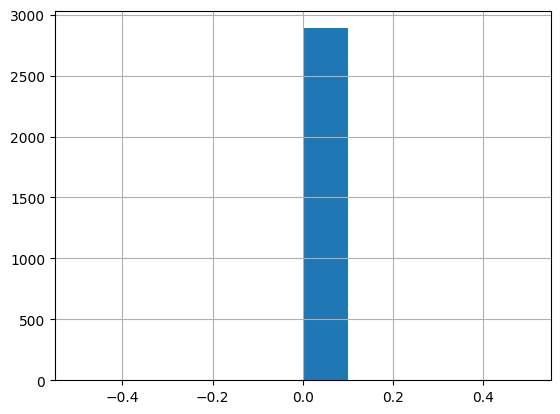

In [7]:
df_test.probability.hist()

In [8]:
ROOT_DIR = '/kaggle/input/UBC-OCEAN'
TRAIN_DIR = '/kaggle/input/tiles-of-cancer-2048px-scale-0-25'
INFER_DIR = '/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25'

df_orig = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
df_orig = df_orig.rename(columns={"label":"subtype"})
df_labelled = pd.read_csv("/kaggle/input/df-tiles-025x-cancer-tissue-binary-labels/tiles_labelled_binary_cancer.csv", index_col="Unnamed: 0")
display(df_orig.sample(5))
display(df_labelled.sample(5))

,image_id,subtype,image_width,image_height,is_tma
182,21445,MC,34200,23705,False
266,32035,HGSC,16861,44075,False
312,38019,MC,59023,43223,False
523,63429,EC,67783,29066,False
129,15470,CC,64751,18986,False


,image_path,mask_path,cancer_ratio,non_cancer_ratio,label
24401,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/46815/00031_1-4.png,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_masks/46815/00031_1-4.png,0.191418,0.0,cancer
9024,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/30738/00072_27-6.png,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_masks/30738/00072_27-6.png,0.083214,0.0,cancer
13883,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/10143/00261_18-16.png,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_masks/10143/00261_18-16.png,0.000000,0.0,unknown
5015,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/37307/00349_13-19.png,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_masks/37307/00349_13-19.png,0.000000,0.0,unknown
37244,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/61424/00013_15-2.png,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_masks/61424/00013_15-2.png,0.000000,0.0,unknown


In [9]:
def prepare_df(df_labelled):
    df_labelled["image_id"] = df_labelled["image_path"].map(lambda x: int(x.split('/')[-2]))
    df_labelled = df_labelled[~df_labelled["image_path"].str.lower().str.contains("tma")]
    df_labelled = df_labelled[df_labelled["label"]!="unknown"].reset_index(drop=True)
    df_labelled = pd.merge(df_labelled, df_orig, on="image_id", how="left")
    df_labelled["group"] = df_labelled["label"] + "_" + df_labelled["subtype"] 
    return df_labelled


df_masks = prepare_df(df_labelled)

In [10]:
directory_path = "/kaggle/input/tiles-of-cancer-2048px-scale-0-25"
df_tiles_all = create_img_dataframe_from_directory(directory_path)
df_tiles_all["image_id"] = df_tiles_all["image_id"].astype(int)
print(df_tiles_all.shape)
print("Example row:", df_tiles_all.iloc[0,0], df_tiles_all.iloc[0,1])
display(df_tiles_all.head()) 

(123714, 2)
Example row: /kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000021_6-2.png 8805


,image_path,image_id
0,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000021_6-2.png,8805
1,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000056_9-4.png,8805
2,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000089_10-6.png,8805
3,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000002_3-1.png,8805
4,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000057_10-4.png,8805


In [11]:
print("Example row:", df_tiles_all.iloc[0,0], df_tiles_all.iloc[0,1])
print("Example row:", df_masks.iloc[0,0], df_masks.iloc[0,1])


Example row: /kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000021_6-2.png 8805
Example row: /kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/53688/00014_8-2.png /kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_masks/53688/00014_8-2.png


In [12]:
df_masks["image_id"].nunique(), df_tiles_all["image_id"].nunique()

(152, 538)

In [13]:
img_color_mean=[0.8661704276539922, 0.7663107094675368, 0.8574260897185548]
img_color_std=[0.08670629753900036, 0.11646580094195522, 0.07164169171856792]

data_transforms = {
    "train": A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
        A.GaussNoise(var_limit=[10, 50]),
        A.GaussianBlur(),
        A.MotionBlur(),
        ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=5, max_width=int(512* 0.1), max_height=int(512* 0.1),
        mask_fill_value=0, p=0.5),
        A.Normalize(img_color_mean, img_color_std), 
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(img_color_mean, img_color_std), 
        ToTensorV2()], p=1.)
}



## 3. Training

In [14]:
class InferBinaryTilesDataset(Dataset):
    """
    Dataset Class which is used in order to read tiles from given folder / path and label them accroding to a binary classifier.
    This is a pure inference dataset. 
    
    """
    def __init__(
        self,
        df_data,
        transforms = None,
        mode: str = 'valid',
        labels_lut = None,
        # train_val_split: float = 0.90,
        tissue_label_th: float = 0.2
    ):

        self.transforms = transforms
        self.mode = mode
        self.data = df_data
        self.img_paths =  self.data.image_path.values.tolist()
        
    def __getitem__(self, idx: int) -> tuple:
        img_path = self.img_paths[idx]
        assert os.path.isfile(img_path), f"missing: {img_path}"
        tile = cv2.imread(img_path)
        tile = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)
        # augmentation
        if self.transforms:
            tile = self.transforms(image=tile)["image"]
        #print(f"img dim: {img.shape}")
        return {
            "image": tile,
            "image_path": img_path,
               }
    
    def __len__(self) -> int:
        return len(self.img_paths)


In [15]:
def metrics(df_pred):
    conf_matrix = confusion_matrix(df_pred["label"], df_pred["predicted_label"])
    accuracy = accuracy_score(df_pred["label"], df_pred["predicted_label"])
    macro_f1 = f1_score(df_pred["label"], df_pred["predicted_label"], average='macro')
    print(macro_f1, accuracy)
    display(conf_matrix)

In [16]:
def infer_on_unlabelled_data(model, CONFIG, df_test, val_size=1.0):
    model.eval()
    infer_dataset = InferBinaryTilesDataset(df_test, transforms=data_transforms["valid"])
    infer_loader = DataLoader(infer_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=2, shuffle=False, pin_memory=True)
    print(f"Test-Dataset Size: {len(infer_dataset)}")

    preds_list = []
    probs_list = []
    image_path_list = []
    #test_acc = 0.0

    with torch.no_grad():
        bar = tqdm(enumerate(infer_loader), total=len(infer_loader))
        for step, data in bar: 
            # print(step)
            images = data['image'].to(CONFIG["device"], dtype=torch.float)
            image_paths = data['image_path'] # .to(CONFIG["device"], dtype=torch.float)

            outputs = model(images)        
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).int()
            #preds_list.append(predicted.detach().cpu().numpy() )
            #probs_list.append(probs.detach().cpu().numpy() )
            #image_path_list.append(image_paths)
            preds_list.extend(predicted.detach().cpu().numpy().ravel())
            probs_list.extend(probs.detach().cpu().numpy().ravel())            
            image_path_list.extend(image_paths)
    # pred_labels = encoder.inverse_transform(preds_list)
    df_infer = pd.DataFrame({
        "image_path": image_path_list,
        "prediction": preds_list,
        "probability": probs_list,
    })
    return df_infer

In [17]:
model = UBCBinaryModel(CONFIG['model_name'], pretrained=False , checkpoint_path=None)
# model_path = "/kaggle/input/binary-tiles-classifier-025x-v6/best_model_checkpoint2023-12-10_10-57-05.pth"
model.load_state_dict(torch.load(CONFIG["model_path"], map_location=CONFIG["device"]))
model.to(CONFIG['device']);

label_dict = {
    0:"cancer",
    1:"non-cancer"}

In [18]:
print(df_test.shape)
df_test.head(2)

(2888, 5)


,image_path,label,predicted_label,prediction,probability
0,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/30738/00071_26-6.png,0.0,cancer,0,0
1,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/36063/00141_31-9.png,0.0,cancer,0,0


In [19]:
print("Infer on Holdout Set:")
df_test_control = infer_on_unlabelled_data(model, CONFIG, df_test)


Infer on Holdout Set:
Test-Dataset Size: 2888


100%|██████████| 91/91 [00:52<00:00,  1.74it/s]


In [20]:
df_test_control["predicted_label"] = encoder.inverse_transform(df_test_control["prediction"])
df_test_control["probability"] = df_test_control["probability"].map(lambda x: np.round(x, 4))
display(df_test_control.head())
print(df_test_control.probability.max())
df_test_control.prediction.value_counts()

,image_path,prediction,probability,predicted_label
0,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/30738/00071_26-6.png,0,0.0000,cancer
1,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/36063/00141_31-9.png,0,0.3267,cancer
2,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/50304/00407_11-19.png,0,0.0000,cancer
3,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/19255/00417_30-15.png,0,0.0009,cancer
4,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/47960/00099_8-7.png,0,0.0000,cancer


1.0


prediction
0    2471
1     417
Name: count, dtype: int64

In [21]:
df_test = pd.merge(df_test[["image_path", "label"]], df_test_control, on="image_path", how="inner")
print(df_test.shape)
display(df_test.head(2))
df_test.to_csv("df_test_025x_predictions.csv")

(2888, 5)


,image_path,label,prediction,probability,predicted_label
0,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/30738/00071_26-6.png,0.0,0,0.0000,cancer
1,/kaggle/input/ubc-ocean-tiles-w-masks-2048px-scale-0-25/train_images/36063/00141_31-9.png,0.0,0,0.3267,cancer


In [22]:
print("Accuracy Testset:", accuracy_score(df_test["label"], df_test["prediction"]))
print("F1-Score Testset:", f1_score(df_test["label"], df_test["prediction"]))

Accuracy Testset: 0.9501385041551247
F1-Score Testset: 0.8043478260869565


In [23]:
print(f"Infer on Holdout Set. Shape: {df_tiles_all.shape}")
df_tiles_labelled = infer_on_unlabelled_data(model, CONFIG, df_tiles_all)
df_tiles_labelled.to_csv("tiles_025x_full_pseudo_labels.csv")
print("inference done!")
df_tiles_labelled.head()

Infer on Holdout Set. Shape: (123714, 2)
Test-Dataset Size: 123714


100%|██████████| 3867/3867 [31:38<00:00,  2.04it/s]


inference done!


,image_path,prediction,probability
0,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000021_6-2.png,0,0.001676
1,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000056_9-4.png,1,0.786360
2,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000089_10-6.png,1,0.981452
3,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000002_3-1.png,0,0.016089
4,/kaggle/input/tiles-of-cancer-2048px-scale-0-25/8805/000057_10-4.png,1,0.860730


In [24]:
df_tiles_labelled = pd.merge(df_tiles_all, df_tiles_labelled, on="image_path", how="inner") 


# Model Evaluation

In [25]:
def evaluate_dual_thresholds(y_true, y_probs):
    thresholds = np.arange(0.0, 1.01, 0.05)
    results = []

    for lower_thresh, upper_thresh in itertools.product(thresholds, repeat=2):
        if lower_thresh >= upper_thresh:
            continue

        y_pred = np.where(y_probs < lower_thresh, 0, np.where(y_probs > upper_thresh, 1, -1)) # -1 for 'unknown'
        known_mask = y_pred != -1

        if np.any(known_mask): # Calculate metrics only if there are 'known' samples
            accuracy = accuracy_score(y_true[known_mask], y_pred[known_mask])
            precision = precision_score(y_true[known_mask], y_pred[known_mask])
            recall = recall_score(y_true[known_mask], y_pred[known_mask])
            f1 = f1_score(y_true[known_mask], y_pred[known_mask])
            results.append((lower_thresh, upper_thresh, accuracy, precision, recall, f1))

    # Sorting results based on F1 score or another metric of choice
    results.sort(key=lambda x: x[5], reverse=True) # Sort by F1 score

    # Plotting the top 10 results
    plt.figure(figsize=(10, 6))
    for i, (lower_thresh, upper_thresh, accuracy, precision, recall, f1) in enumerate(results[:10]):
        plt.plot([lower_thresh, upper_thresh], [f1, f1], label=f'Thresholds: {lower_thresh:.2f}-{upper_thresh:.2f}')

    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('Evaluation of Different Threshold Pairs')
    plt.legend()
    plt.show()

In [26]:
# evaluate_dual_thresholds(df_test_control["label"], df_test_control["probability"])add_suffix

In [27]:
"""
df_v1 = pd.read_csv("/kaggle/input/df-test-binary-v1/df_test_025x_predictions.csv")
df_v1.head()
print("Size: ", df_v1.shape)
print("Accuracy Testset:", accuracy_score(df_v1["label"], df_v1["prediction"]))
print("F1-Score Testset:", f1_score(df_v1["label"], df_v1["prediction"]))
print("Confusion Testset:", confusion_matrix(df_v1["label"], df_v1["prediction"]))
df_filtered = df_v1[(df_v1["probability"]<0.2) | (df_v1["probability"]>0.8)]
print("Size: ", df_filtered.shape)
print("Accuracy Testset:", accuracy_score(df_filtered["label"], df_filtered["prediction"]))
print("F1-Score Testset:", f1_score(df_filtered["label"], df_filtered["prediction"]))
print("Confusion Testset:", confusion_matrix(df_filtered["label"], df_filtered["prediction"]))
df_filtered = df_v1[(df_v1["probability"]<0.1) | (df_v1["probability"]>0.9)]
print("Size: ", df_filtered.shape)
print("Accuracy Testset:", accuracy_score(df_filtered["label"], df_filtered["prediction"]))
print("F1-Score Testset:", f1_score(df_filtered["label"], df_filtered["prediction"]))
print("Confusion Testset:", confusion_matrix(df_filtered["label"], df_filtered["prediction"]))
df_filtered = df_v1[(df_v1["probability"]<0.01) | (df_v1["probability"]>0.9)]
print("Size: ", df_filtered.shape)
print("Accuracy Testset:", accuracy_score(df_filtered["label"], df_filtered["prediction"]))
print("F1-Score Testset:", f1_score(df_filtered["label"], df_filtered["prediction"]))
print("Confusion Testset:", confusion_matrix(df_filtered["label"], df_filtered["prediction"]))"""

'\ndf_v1 = pd.read_csv("/kaggle/input/df-test-binary-v1/df_test_025x_predictions.csv")\ndf_v1.head()\nprint("Size: ", df_v1.shape)\nprint("Accuracy Testset:", accuracy_score(df_v1["label"], df_v1["prediction"]))\nprint("F1-Score Testset:", f1_score(df_v1["label"], df_v1["prediction"]))\nprint("Confusion Testset:", confusion_matrix(df_v1["label"], df_v1["prediction"]))\ndf_filtered = df_v1[(df_v1["probability"]<0.2) | (df_v1["probability"]>0.8)]\nprint("Size: ", df_filtered.shape)\nprint("Accuracy Testset:", accuracy_score(df_filtered["label"], df_filtered["prediction"]))\nprint("F1-Score Testset:", f1_score(df_filtered["label"], df_filtered["prediction"]))\nprint("Confusion Testset:", confusion_matrix(df_filtered["label"], df_filtered["prediction"]))\ndf_filtered = df_v1[(df_v1["probability"]<0.1) | (df_v1["probability"]>0.9)]\nprint("Size: ", df_filtered.shape)\nprint("Accuracy Testset:", accuracy_score(df_filtered["label"], df_filtered["prediction"]))\nprint("F1-Score Testset:", f1_s